In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm

In [2]:
!pip install causalml

     |████████████████████████████████| 406 kB 14.8 MB/s 
     |████████████████████████████████| 564 kB 59.1 MB/s 
     |████████████████████████████████| 1.8 MB 50.0 MB/s 
     |████████████████████████████████| 718 kB 54.3 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050925 sha256=994809cfd60ecf2107192133f8040d2d821721555a3ad8ffae87e544d66eebc6
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [3]:
!pip install pylift

     |████████████████████████████████| 100 kB 5.7 MB/s 
  Created wheel for pylift: filename=pylift-0.1.5-py3-none-any.whl size=26030 sha256=0cd294c1b93fa27bc8e60d42af39e6bbd7b87b66f22626b9a9add8323a53646d
  Stored in directory: /root/.cache/pip/wheels/c3/ec/9d/69405e922f27de16e66aada83dce7227f6fddc71639d7cfe66
Successfully built pylift


In [4]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 59 kB/s 


EDA Criteo

In [5]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# import dask.dataframe as dd
import numpy as np
import scipy as sp

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from IPython.display import Image

seed=10

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dataset = fetch_criteo(target_col='all', treatment_col='all')

In [3]:
type(dataset), len(dataset)

(sklearn.utils.Bunch, 7)

In [4]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (13979592, 12)
Dataset target shape: (13979592, 2)
Dataset treatment shape: (13979592, 2)


In [5]:
dataset.feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

In [6]:
dataset.data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01


In [7]:
dataset.target_name, dataset.treatment_name

(['visit', 'conversion'], ['exposure', 'treatment'])

In [8]:
cols_features = [
    "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"
]

col_treatment = 'treatment'

In [9]:
X, y, t = dataset.data, dataset.target, dataset.treatment

In [10]:
X.shape, y.shape, t.shape

((13979592, 12), (13979592, 2), (13979592, 2))

In [11]:
y.columns, t.columns

(Index(['visit', 'conversion'], dtype='object'),
 Index(['exposure', 'treatment'], dtype='object'))

In [12]:
X.head().append(X.tail())

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679
13979591,12.616365,10.059654,8.214383,4.679882,10.280525,3.013064,0.294443,9.332563,3.971858,13.190056,5.300375,-0.168679


In [13]:
print('X, Number NA:', X.isna().sum().sum())
print('y, Number NA:', y.isna().sum().sum())
print('t, Number NA:', t.isna().sum().sum())

X, Number NA: 0
y, Number NA: 0
t, Number NA: 0


In [14]:
t['treatment'].value_counts(normalize = True)

1    0.85
0    0.15
Name: treatment, dtype: Float64

In [15]:
t['exposure'].value_counts(normalize = True)
t = t.drop('exposure',axis=1)

In [16]:
print(y['visit'].value_counts(normalize = True))
print(y['visit'].sum())

0    0.953008
1    0.046992
Name: visit, dtype: Float64
656929


In [17]:
y['conversion'].value_counts(normalize = True)

0    0.997083
1    0.002917
Name: conversion, dtype: Float64

In [18]:
X.shape, y.shape, t.shape

((13979592, 12), (13979592, 2), (13979592, 1))

In [19]:
data = X.join(y)
data = data.join(t)
print(data.shape)

(13979592, 15)


In [22]:
data.head().append(data.tail())

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,visit,conversion,treatment
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,1
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,1
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,1
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,1
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,1
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,0,0,1
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,1
13979591,12.616365,10.059654,8.214383,4.679882,10.280525,3.013064,0.294443,9.332563,3.971858,13.190056,5.300375,-0.168679,0,0,1


In [23]:
visit_pivot = data.groupby('treatment').agg({'visit': ['mean', 'sum', 'count']})
visit_pivot

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [24]:
conversion_pivot = data.groupby('treatment').agg({'conversion': ['mean', 'sum', 'count']})
conversion_pivot

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [24]:
print(f'Difference in CTR rate between control and treatment: {np.round(data.groupby("treatment")["visit"].mean()[1] - data.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(data.groupby("treatment")["conversion"].mean()[1] - data.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in CTR rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


In [20]:
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.tlearner as tlearner
from scipy.stats import chi2_contingency
from typing import List, Tuple

In [21]:
data.nunique()

f0            2181959
f1                 60
f2            2051900
f3                552
f4                260
f5                132
f6               1645
f7             622143
f8               3743
f9               1594
f10            517372
f11               136
visit               2
conversion          2
treatment           2
dtype: int64

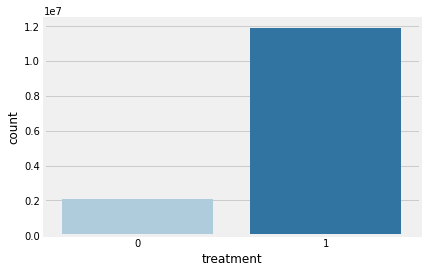

In [73]:
sns.countplot(x=data.treatment)

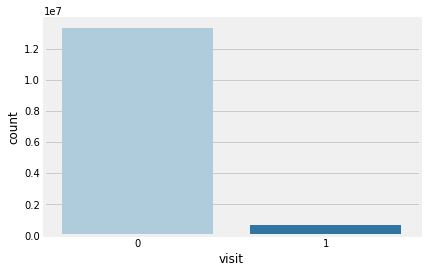

In [23]:
sns.countplot(x=data.visit)

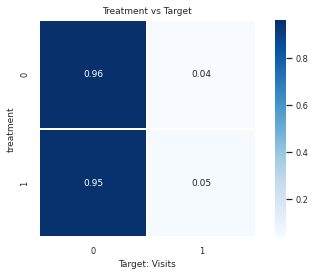

In [86]:
# plt.figure(figsize = (14,8))
# sns.set(font_scale=0.75)
crosstab = pd.crosstab(data.treatment, data.visit, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = "Blues")
plt.xlabel("Target: Visits")
plt.title("Treatment vs Target");

The `size` parameter has been renamed to `height`; please update your code.


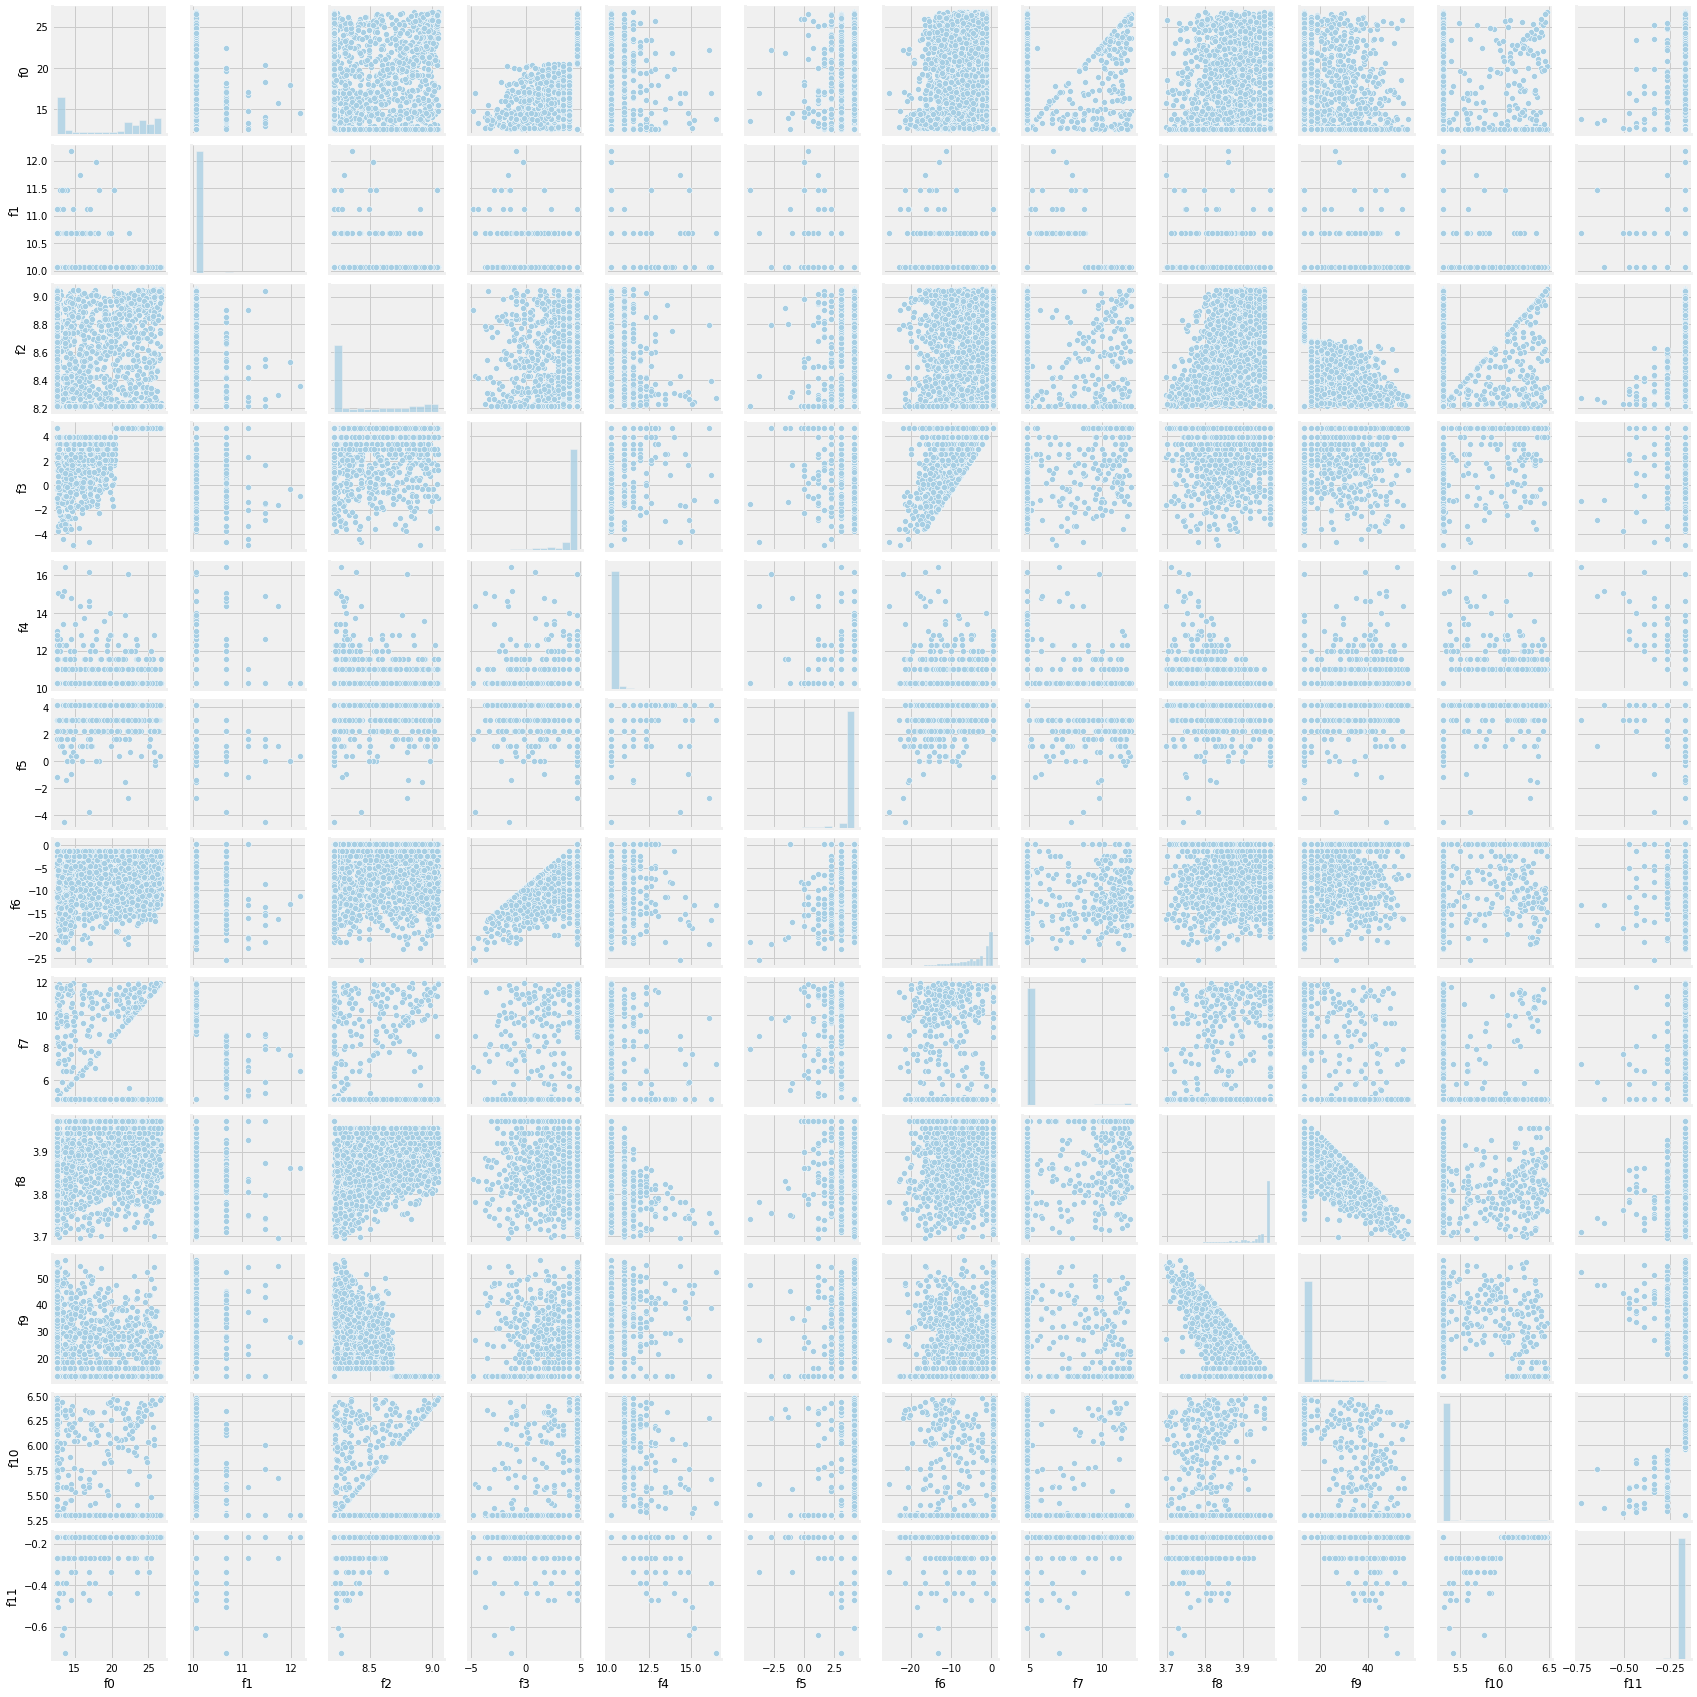

In [79]:
sns.pairplot(data[cols_features].sample(5000), size=2)

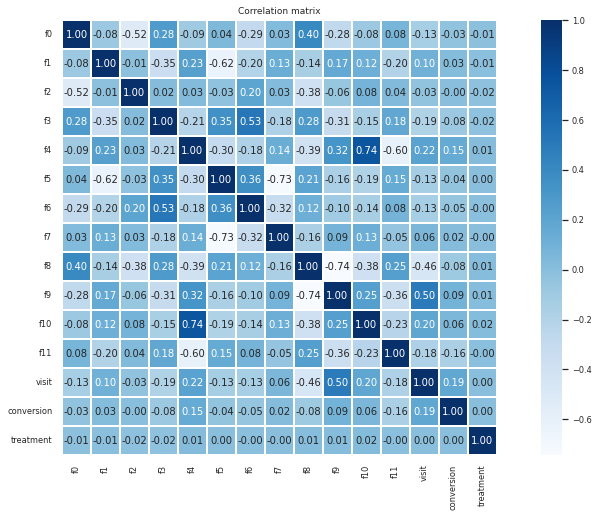

In [29]:
# heatmap to target
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(data[data.columns].sample(5000).corr().round(3), annot=True, square = True,
            linewidths=.75, cmap="Blues", fmt = ".2f", annot_kws = {"size": 10})
plt.title("Correlation matrix")
plt.show()

In [52]:
# y = y.drop('conversion',axis=1)

(13979592, 1)

EDA Hillstorm

In [34]:
from sklift.datasets import fetch_hillstrom

dataset_hillstorm = fetch_hillstrom(target_col='all')
data, target, treatment = dataset_hillstorm.data, dataset_hillstorm.target, dataset_hillstorm.treatment

In [35]:
data.shape, target.shape, treatment.shape

((64000, 8), (64000, 3), (64000,))

In [44]:
target.columns.values

array(['visit', 'conversion', 'spend'], dtype=object)

In [43]:
treatment.name

'segment'

In [37]:
print('X, Number NA:', data.isna().sum().sum())
print('y, Number NA:', target.isna().sum().sum())
print('t, Number NA:', treatment.isna().sum().sum())

X, Number NA: 0
y, Number NA: 0
t, Number NA: 0


In [45]:
data_hillstrom = data.join(target)
data_hillstrom = data_hillstrom.join(treatment)
print(data_hillstrom.shape)

(64000, 12)


In [46]:
data_hillstrom.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,visit,conversion,spend,segment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,0,0,0.0,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,0,0.0,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,0,0,0.0,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,0,0,0.0,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,0,0,0.0,Womens E-Mail


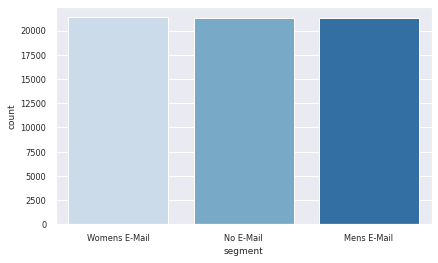

In [54]:
sns.countplot(x=data_hillstrom.segment, palette = "Blues")

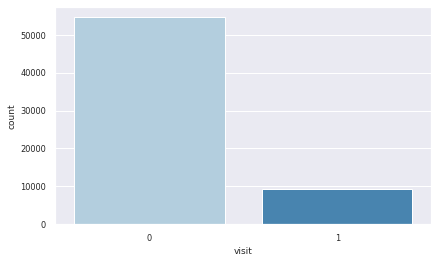

In [56]:
sns.countplot(x=data_hillstrom.visit, palette = "Blues")

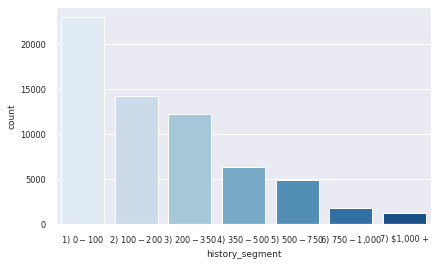

In [61]:
sns.countplot(x=data_hillstrom.history_segment, palette = "Blues", order=data_hillstrom.history_segment.value_counts().index)

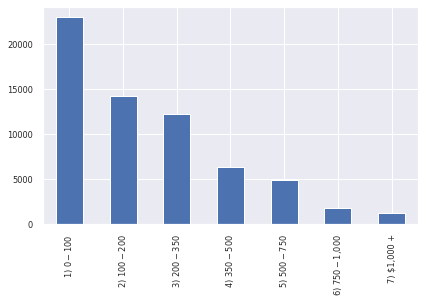

In [60]:
data_hillstrom.history_segment.value_counts().plot(kind="bar")

In [65]:
features = np.setdiff1d(data_hillstrom.columns, ['visit', 'segment', 'conversion'] ).tolist()
dfX = data_hillstrom[features]
dfX.tail(4)

,channel,history,history_segment,mens,newbie,recency,spend,womens,zip_code
63996,Phone,38.91,1) $0 - $100,0,1,5,0.0,1,Urban
63997,Phone,29.99,1) $0 - $100,1,1,6,0.0,0,Urban
63998,Multichannel,552.94,5) $500 - $750,1,1,1,0.0,0,Surburban
63999,Web,472.82,4) $350 - $500,0,0,1,0.0,1,Surburban


In [66]:
# one-hot encoding: categorical to numerical
dfXn = pd.get_dummies(dfX)
dfXn.tail(4)

,history,mens,newbie,recency,spend,womens,channel_Multichannel,channel_Phone,channel_Web,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban
63996,38.91,0,1,5,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,1
63997,29.99,1,1,6,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
63998,552.94,1,1,1,0.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
63999,472.82,0,0,1,0.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0


In [68]:
dfXn = dfXn.join(data_hillstrom.segment)

In [70]:
dfXn.columns

Index(['history', 'mens', 'newbie', 'recency', 'spend', 'womens',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment_1) $0 - $100', 'history_segment_2) $100 - $200',
       'history_segment_3) $200 - $350', 'history_segment_4) $350 - $500',
       'history_segment_5) $500 - $750', 'history_segment_6) $750 - $1,000',
       'history_segment_7) $1,000 +', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'segment'],
      dtype='object')

In [74]:
dct = {'No E-Mail':0, 'Womens E-Mail':1, 'Mens E-Mail':2}
dfXn['segment'] = dfXn['segment'].map(dct)

In [75]:
dfXn.head()

,history,mens,newbie,recency,spend,womens,channel_Multichannel,channel_Phone,channel_Web,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,segment
0,142.44,1,0,10,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1
1,329.08,1,1,6,0.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,180.65,0,1,7,0.0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1
3,675.83,1,1,9,0.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,2
4,45.34,1,0,2,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1


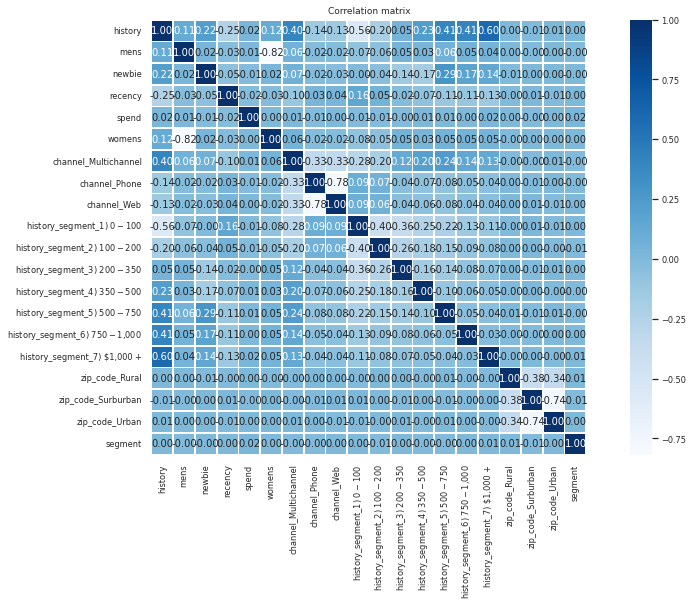

In [76]:
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="Blues", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("Correlation matrix")
plt.show()

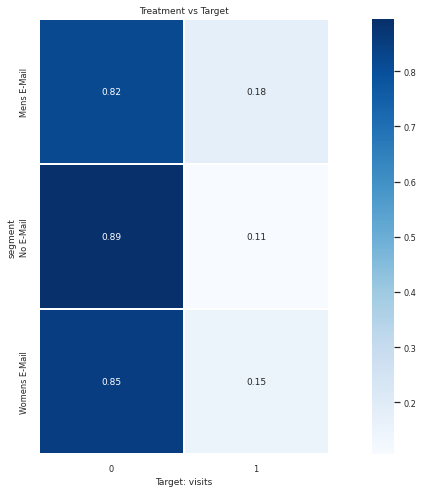

In [77]:
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
crosstab = pd.crosstab(data_hillstrom.segment, data_hillstrom.visit, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = "Blues")
plt.xlabel("Target: visits")
plt.title("Treatment vs Target");

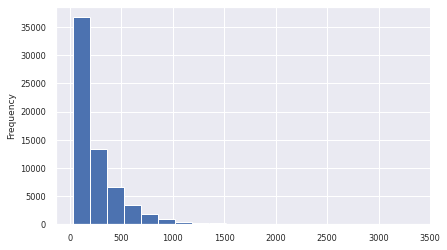

In [82]:
# Доходность за t период 
data_hillstrom.history.plot(kind="hist", bins=20)

EDA Syntetic Data

In [6]:
# Generate synthetic data using mode 1
from causalml.dataset import *
from causalml.metrics import *

y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [8]:
pd.Series(treatment).value_counts()

control        4780
treatment_a    4192
treatment_b    1028
dtype: int64

In [9]:
X.shape, y.shape

((10000, 8), (10000,))

In [10]:
print(X)

[[0.74829605 0.78646341 0.69722673 ... 0.90484522 0.61325561 0.39647446]
 [0.4493823  0.11309921 0.41671284 ... 0.05773025 0.86296393 0.16842186]
 [0.43014772 0.08510283 0.46155856 ... 0.37149955 0.74795903 0.18126261]
 ...
 [0.57961936 0.98479169 0.35120937 ... 0.55546799 0.9569039  0.71769738]
 [0.7185462  0.16732038 0.39821185 ... 0.10651722 0.17440489 0.94926964]
 [0.19843963 0.50840776 0.47315029 ... 0.71755845 0.1636824  0.89549454]]


In [11]:
print(y)

[1.84967024 0.86281299 0.20245286 ... 2.9168171  2.19674394 1.2813524 ]


In [12]:
print(e), print(tau), print(b)

{'control': array([0.9       , 0.15899317, 0.11475029, ..., 0.9       , 0.36878876,
       0.31166972]), 'treatment_a': array([0.9       , 0.15899317, 0.11475029, ..., 0.9       , 0.36878876,
       0.31166972]), 'treatment_b': array([0.9       , 0.15899317, 0.11475029, ..., 0.9       , 0.36878876,
       0.31166972])}
[0.76737973 0.28124075 0.25762528 ... 0.78220552 0.44293329 0.35342369]
[1.74798303 0.93049134 0.79161056 ... 1.91283608 1.51092307 1.30053676]


(None, None, None)

In [13]:
print(len(e)), print(len(tau)), print(len(b))

3
10000
10000


(None, None, None)

In [34]:
e['control'].shape, e['treatment_a'].shape, e['treatment_b'].shape, 

((10000,), (10000,), (10000,))

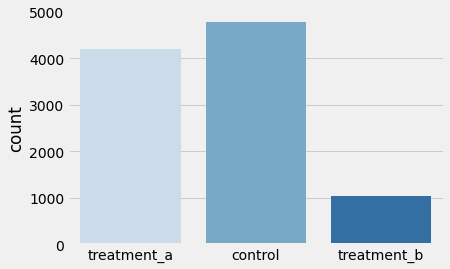

In [14]:
sns.countplot(x=pd.Series(treatment), palette = "Blues")

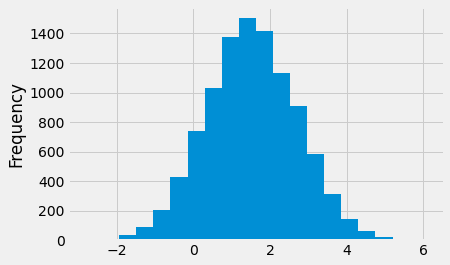

In [15]:
pd.Series(y).plot(kind="hist", bins=20)

In [16]:
target = pd.Series(y)
target.name = 'y'

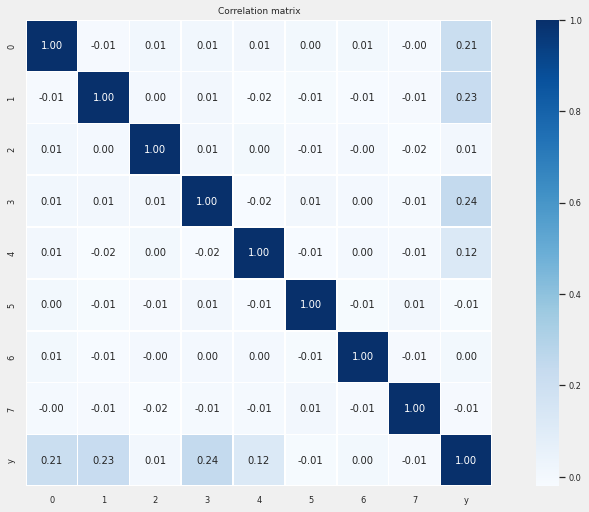

In [17]:
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(pd.DataFrame(X).join(target).corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="Blues", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("Correlation matrix")
plt.show()

In [18]:
X.shape

(10000, 8)

In [27]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# import dask.dataframe as dd
import numpy as np
import scipy as sp

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from IPython.display import Image

seed=10

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from xgboost import XGBRegressor, XGBClassifier

In [45]:
pd.Series(treatment).value_counts()

control        4780
treatment_a    4192
treatment_b    1028
dtype: int64

In [47]:
treatment = pd.Series(treatment).apply(lambda t: 0 if t == 'control'  else (1 if t == 'treatment_a' else 2)) 

In [48]:
treatment.value_counts()

0    4780
1    4192
2    1028
dtype: int64

In [49]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    X,
    treatment,
    target,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (7000, 8)
Validation shape: (3000, 8)


In [50]:
learner_s = BaseSRegressor(XGBRegressor(), control_name=0)
ate_s = learner_s.estimate_ate(X=X_train, treatment=trmnt_train, y=y_train, return_ci=False, bootstrap_ci=False)

[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
ate_s

array([0.58824239, 0.6308351 ])

In [52]:
learner_s._classes

{1: 0, 2: 1}

In [53]:
s_learner_pred = pd.DataFrame(learner_s.predict(X_val))
s_learner_pred = s_learner_pred.rename(columns={0:'score'})

s_learner_pred = s_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
s_learner_pred = s_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

In [60]:
cols = ['score', 1]
s_learner_pred['max'] = s_learner_pred[cols].max(axis=1)

In [61]:
s_learner_pred.head()

,score,1,treatment,target,max
0,0.254628,0.492285,2,1.347542,0.492285
1,0.365885,0.625867,0,0.413810,0.625867
2,0.754748,0.754504,1,2.372762,0.754748
3,0.816673,0.410767,2,1.154671,0.816673
4,0.402760,0.573061,1,1.364383,0.573061


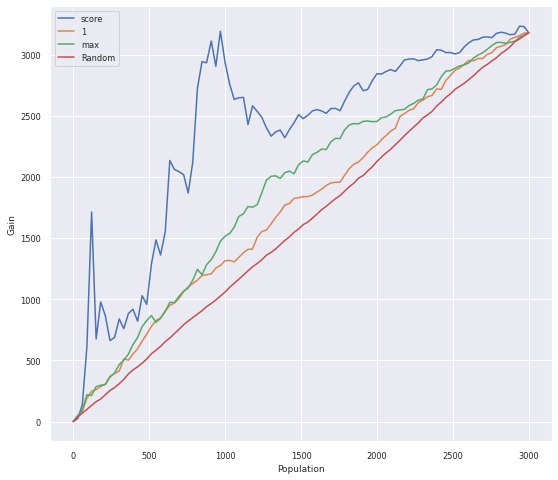

In [62]:
cmetrics.plot_gain(
    s_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)